In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
%matplotlib inline

[nltk_data] Downloading package wordnet to /home/ilja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission_most_popular.csv')

In [3]:
train = train[['dialogue', 'genres']]
train.head()

,dialogue,genres
0,I thought you were in a meeting--? <BR> I am. ...,"[u'drama', u'romance']"
1,Are you sure you're okay? You're pale. <BR> I...,[u'drama']
2,Go on! Get out! <BR> Mom look don't say anythi...,[u'comedy']
3,I could have lost my fucking hands. <BR> That ...,"[u'mystery', u'thriller']"
4,Stick with me on this Gloria. I need you... <...,"[u'crime', u'thriller']"


In [4]:
train_X, valid_X = train_test_split(train, test_size=0.3, random_state=42)
#train_X = train

In [5]:
new_train = []
for item in train_X.iterrows():
    genres = item[1].genres[1:-1].split(', ')
    genres = [s[2:-1] for s in genres]
    for genre in genres:
        copy_item = item[1].copy()
        copy_item.genres = genre
        new_train.append(copy_item)
new_train = pd.DataFrame(new_train).reset_index(drop=True)

In [6]:
new_train.head()

,dialogue,genres
0,You can't stop me from seeing her Mrs. Robinso...,comedy
1,You can't stop me from seeing her Mrs. Robinso...,romance
2,I can't believe I just did that. <BR> Do you t...,horror
3,I can't believe I just did that. <BR> Do you t...,thriller
4,No part of it wasn't real. <BR> I know. And n...,drama


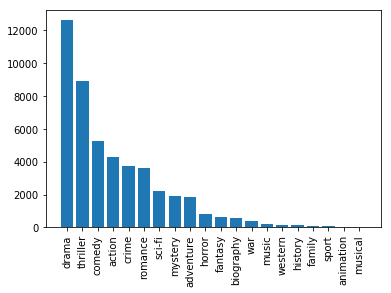

In [7]:
counts = new_train['genres'].value_counts()
plt.bar(height=counts, x=counts.index)
plt.xticks(rotation=90);

In [8]:
counts

drama        12617
thriller      8898
comedy        5253
action        4267
crime         3764
romance       3627
sci-fi        2212
mystery       1907
adventure     1879
horror         829
fantasy        641
biography      574
war            395
music          180
western        134
history        126
family         101
sport           78
animation       36
musical         30
Name: genres, dtype: int64

In [248]:
counts_dict = {}
for i in range(len(counts)):
    counts_dict[counts.index[i]] = min(12644 // counts[i], 2)

In [10]:
le = LabelEncoder()
new_train.genres = le.fit_transform(new_train.genres)

In [11]:
le.classes_

array(['action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'drama', 'family', 'fantasy', 'history', 'horror', 'music',
       'musical', 'mystery', 'romance', 'sci-fi', 'sport', 'thriller',
       'war', 'western'], dtype=object)

In [12]:
counts_dict

NameError: name 'counts_dict' is not defined

In [251]:
# up_train = []
# for i in range(len(new_train)):
#     mult = counts_dict[new_train.iloc[i].genres]
#     for j in range(mult):
#         up_train.append(new_train.iloc[i])
# up_train = pd.DataFrame(up_train).reset_index(drop=True)
# trell = up_train[up_train.genres == 'thriller'].sample(3000)
# new_train = pd.concat([up_train.copy(), trell], axis=0)

In [253]:
new_train.head()

,dialogue,genres
0,You can't stop me from seeing her Mrs. Robinso...,4
1,You can't stop me from seeing her Mrs. Robinso...,14
2,I can't believe I just did that. <BR> Do you t...,10
3,I can't believe I just did that. <BR> Do you t...,17
4,No part of it wasn't real. <BR> I know. And n...,6


In [254]:
# def get_wordnet_pos(word):
#     """Map POS tag to first character lemmatize() accepts"""
#     tag = nltk.pos_tag([word])[0][1][0].upper()
#     tag_dict = {"J": wordnet.ADJ,
#                 "N": wordnet.NOUN,
#                 "V": wordnet.VERB,
#                 "R": wordnet.ADV}
#     return tag_dict.get(tag, wordnet.NOUN)

In [255]:
# lemmatizer = WordNetLemmatizer()

In [13]:
for i in range(len(valid_X)):
    genres = valid_X.iloc[i, 1][1:-1].split(', ')
    genres = [s[2:-1] for s in genres]
    genres = le.transform(genres)
    valid_X.iloc[i]['genres'] = genres

In [14]:
valid_X.head()

,dialogue,genres
9550,Sure you wanna do this? Might be a way they co...,"[5, 17]"
7112,he's just playing Q... <BR> You think for once...,[6]
9545,A man doesn't always know why he does things L...,"[6, 10, 13, 17]"
10261,Who isn't? <BR> You been followin' the news co...,"[0, 5, 6, 17]"
9876,That was a really hot house! <BR> So your name...,"[4, 6]"


In [15]:
def f1_sc(y, pred):
    tp = 0
    for elem in pred:
        if elem in y:
            tp += 1
    rec = tp / len(y)
    pres = tp / len(pred)
    if rec * pres == 0:
        return 0
    f = 2 * rec * pres / (rec + pres)
    return f

In [92]:
stemmer = PorterStemmer()
words = stopwords.words("english")
new_train['cleaned'] = new_train['dialogue'].apply(lambda x: " ".join(re.sub("[^a-zA-Z']", " ", x).split()).lower())
new_train['cleaned'] = new_train['cleaned'].apply(lambda s: s.replace('<br>', ' '))
# new_train['cleaned'] = new_train['cleaned'].apply(lambda s: s.replace('!', ' ! '))
# new_train['cleaned'] = new_train['cleaned'].apply(lambda s: s.replace('?', ' ? '))
#new_train['cleaned'] = new_train['cleaned'].apply(lambda s: " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(s)]))
#new_train['cleaned'] = new_train['cleaned'].apply(lambda x: " ".join([i for i in x.split() if i not in words]))
#new_train['cleaned'] = new_train['cleaned'].apply(lambda x: " ".join([stemmer.stem(i) for i in x.split()]))

In [93]:
valid_X['cleaned'] = valid_X['dialogue'].apply(lambda x: " ".join(re.sub("[^a-zA-Z']", " ", x).split()).lower())
valid_X['cleaned'] = valid_X['cleaned'].apply(lambda s: s.replace('<br>', ' '))
# valid_X['cleaned'] = valid_X['cleaned'].apply(lambda s: s.replace('!', ' ! '))
# valid_X['cleaned'] = valid_X['cleaned'].apply(lambda s: s.replace('?', ' ? '))
#valid_X['cleaned'] = valid_X['cleaned'].apply(lambda s: " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(s)]))
#valid_X['cleaned'] = valid_X['cleaned'].apply(lambda x: " ".join([i for i in x.split() if i not in words]))
#valid_X['cleaned'] = valid_X['cleaned'].apply(lambda x: " ".join([stemmer.stem(i) for i in x.split()]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [94]:
test['cleaned'] = test['dialogue'].apply(lambda x: " ".join(re.sub("[^a-zA-Z']", " ", x).split()).lower())
test['cleaned'] = test['cleaned'].apply(lambda s: s.replace('<br>', ' '))
# test['cleaned'] = test['cleaned'].apply(lambda s: s.replace('!', ' ! '))
# test['cleaned'] = test['cleaned'].apply(lambda s: s.replace('?', ' ? '))
#test['cleaned'] = test['cleaned'].apply(lambda s: " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(s)]))
#test['cleaned'] = test['cleaned'].apply(lambda x: " ".join([i for i in x.split() if i not in words]))
#test['cleaned'] = test['cleaned'].apply(lambda x: " ".join([stemmer.stem(i) for i in x.split()]))

In [85]:
test.dialogue[0]

"Boy! Did you see the way Mama whopped that deputy with her shoe? Knocked the gun right out ... <BR> I don't want you hanging around there hear?"

In [86]:
test.cleaned[0]

"boy !  did you see the way mama whopped that deputy with her shoe ?  knocked the gun right out br i don't want you hanging around there hear ? "

In [107]:
vectorizer = TfidfVectorizer(stop_words=None, dtype='int8', min_df=2, max_df=0.5)
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=14200)),
                     ('clf', LogisticRegression(penalty='l2', C=3, solver='lbfgs'))])
pipeline.fit(new_train.cleaned, new_train.genres)

/usr/local/lib/python3.5/dist-packages/sklearn/feature_extraction/text.py:1547: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int8 'dtype' will be converted to np.float64.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs faile

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype='int8', encoding='utf-8', input='content', lowercase=True,
        max_df=0.5, max_features=None, min_df=2, ngram_range=(1, 1),
        norm='l2', preprocessor=None, smooth_idf=True, stop_words=None,
...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [108]:
pred = pipeline.predict_proba(valid_X.cleaned)

In [109]:
pred_max = np.argmax(pred, axis=1)
result = [0] * len(pred)
for i in range(len(pred)):
    pred[i, pred_max[i]] = 0.5
    result[i] = np.arange(20)[pred[i] > 0.15]

In [110]:
score = 0
for i in range(len(result)):
    score += f1_sc(valid_X.genres.values[i], result[i])
score = score / len(result)
print(score)

0.6724986197999658


In [90]:
0.6724986197999658

0.6724986197999658

In [111]:
score = [0] * len(result)
for i in range(len(result)):
    score[i] = f1_sc(valid_X.genres.values[i], result[i])
#score = score / len(result)
valid_X['score'] = score
valid_X['pred'] = result

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [112]:
le.classes_[17]

'thriller'

In [113]:
valid_X[valid_X.score < 0.2]

,dialogue,genres,cleaned,score,pred
14788,Took 'em out with a heat seeker. <BR> There's ...,"[0, 17]",took 'em out with a heat seeker br there's som...,0.0,"[6, 13]"
16178,A seeding spends its entire life reaching towa...,"[0, 17]",a seeding spends its entire life reaching towa...,0.0,"[1, 15]"
27176,Shhh... It's okay. <BR> Ray have you been here...,[4],shhh it's okay br ray have you been here all t...,0.0,[6]
31057,Jack I'm as conniving as they come but a sneak...,"[9, 17]",jack i'm as conniving as they come but a sneak...,0.0,"[6, 14]"
7270,You sure you didn't pick up my hair tie? <BR> ...,[17],you sure you didn't pick up my hair tie br hel...,0.0,"[4, 6, 14]"
13366,Ask me? <BR> Ask Jack. It's his old stamping g...,"[5, 17]",ask me br ask jack it's his old stamping ground,0.0,[14]
36223,I'll tell Mike I'm sick. There's a game tonigh...,[17],i'll tell mike i'm sick there's a game tonight...,0.0,"[6, 14]"
21936,Fag. <BR> C'mon man like you really thought yo...,[17],fag br c'mon man like you really thought you w...,0.0,[6]
14381,Paraffin came up positive. And bullet holes ar...,"[0, 5]",paraffin came up positive and bullet holes are...,0.0,"[4, 17]"
35866,This was taken when Richter was arrested in Wa...,[5],this was taken when richter was arrested in wa...,0.0,"[6, 17]"


In [114]:
pred = pipeline.predict_proba(test.cleaned)
pred_max = np.argmax(pred, axis=1)
result = [0] * len(pred)
for i in range(len(pred)):
    pred[i, pred_max[i]] = 0.5
    result[i] = le.classes_[pred[i] > 0.15]

In [115]:
result = [' '.join(x) for x in result]

In [116]:
test['genres'] = result

In [117]:
test.dialogue[9]

'We combine everything. You are my second in command. <BR> What about the share. <BR> You get fifteen percent. <BR> I got partners. <BR> Your Calabrian friend I will accept. At least Costello eats pasta like us. <BR> And the Jews? <BR> Share with them as you wish. Do business with them on your own. But no filthy Jew will ever be a brother to me.'

In [118]:
test.cleaned[9]

'we combine everything you are my second in command br what about the share br you get fifteen percent br i got partners br your calabrian friend i will accept at least costello eats pasta like us br and the jews br share with them as you wish do business with them on your own but no filthy jew will ever be a brother to me'

In [119]:
test[['id', 'genres']].to_csv('answer_7.csv', index=False)